In [55]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hist


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

import xgboost as xgb
import shap


In [56]:
# Check if xgboost is available
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

In [57]:
file = uproot.open("unweighted_events.root")
tree = file["LHEF"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | int32_t                  | AsDtype('>i4')
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.Npart... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | double[]                 | AsJagged(AsDtype('>f8'))
Event/Event.ScalePDF | double[]                 | AsJagged(AsDtype('>f8'))
Event/Event.Coupl... | double[]                 | AsJagged(AsDtype('>f8'))
Event/Event.Coupl... | double[]                 | AsJagged(AsDtype('>f8'))
Event_size           | int32_t                  | AsDtype('>i4')
Rwgt                 | int32_t   

In [58]:
tree.keys()

['Event',
 'Event/Event.fUniqueID',
 'Event/Event.fBits',
 'Event/Event.Number',
 'Event/Event.Nparticles',
 'Event/Event.ProcessID',
 'Event/Event.Weight',
 'Event/Event.ScalePDF',
 'Event/Event.CouplingQED',
 'Event/Event.CouplingQCD',
 'Event_size',
 'Rwgt',
 'Rwgt/Rwgt.fUniqueID',
 'Rwgt/Rwgt.fBits',
 'Rwgt/Rwgt.Weight',
 'Rwgt_size',
 'Particle',
 'Particle/Particle.fUniqueID',
 'Particle/Particle.fBits',
 'Particle/Particle.PID',
 'Particle/Particle.Status',
 'Particle/Particle.Mother1',
 'Particle/Particle.Mother2',
 'Particle/Particle.ColorLine1',
 'Particle/Particle.ColorLine2',
 'Particle/Particle.Px',
 'Particle/Particle.Py',
 'Particle/Particle.Pz',
 'Particle/Particle.E',
 'Particle/Particle.M',
 'Particle/Particle.PT',
 'Particle/Particle.Eta',
 'Particle/Particle.Phi',
 'Particle/Particle.Rapidity',
 'Particle/Particle.LifeTime',
 'Particle/Particle.Spin',
 'Particle_size']

In [59]:
event_tree = tree["Event"]
rwt_tree = tree["Rwgt"]
particle_tree = tree["Particle"]

weights = rwt_tree["Rwgt.Weight"].array()
print("weights shape:", ak.num(weights), len(weights[0]))

pid = particle_tree["Particle.PID"].array()
pt  = particle_tree["Particle.PT"].array()
eta = particle_tree["Particle.Eta"].array()
phi = particle_tree["Particle.Phi"].array()
status = particle_tree["Particle.Status"].array()

px  = particle_tree["Particle.Px"].array()
py  = particle_tree["Particle.Py"].array()
pz  = particle_tree["Particle.Pz"].array()
E   = particle_tree["Particle.E"].array()
pt  = particle_tree["Particle.PT"].array()

print("Number of events:", len(pid))
print("Particles in first event:", len(pid[0]))

print("First event weights:", weights[0])
print("First event PIDs:", pid[0])
print("First event PTs:", pt[0])


weights shape: [19, 19, 19, 19, 19, 19, 19, 19, 19, ..., 19, 19, 19, 19, 19, 19, 19, 19, 19] 19
Number of events: 10000
Particles in first event: 8
First event weights: [0.239, 0.239, 0.239, 0.239, 0.239, ..., 0.239, 0.239, 0.239, 0.239, 0.239]
First event PIDs: [2, -2, 23, 23, -11, 11, 12, -12]
First event PTs: [0, 0, 48.5, 48.5, 17.9, 56.7, 12.9, 59]


In [60]:
#Leptons
final_status = (status == 1)
electrons = abs(pid) == 11
muons = abs(pid) == 13

leptons = final_status & (electrons | muons)

lep_px  = px[leptons]
lep_py  = py[leptons]
lep_pz  = pz[leptons]
lep_E   = E[leptons]
lep_pt  = pt[leptons]
lep_pid = pid[leptons]

#Neutrinos
neutrinos = final_status & ((abs(pid) == 12) | (abs(pid) == 14) | (abs(pid) == 16))

nu_px = px[neutrinos]
nu_py = py[neutrinos]
nu_pz = pz[neutrinos]
nu_E  = E[neutrinos]
nu_pt = pt[neutrinos]

#Two leptons results
n_lep = ak.num(lep_pt)
good_events = (n_lep == 2)

lep_px = lep_px[good_events]
lep_py = lep_py[good_events]
lep_pz = lep_pz[good_events]
lep_E  = lep_E[good_events]
lep_pt = lep_pt[good_events]
lep_pid = lep_pid[good_events]

nu_px = nu_px[good_events]
nu_py = nu_py[good_events]
nu_pt = nu_pt[good_events]
weights = weights[good_events]

#Leading lepton pT
leading_pt = ak.to_numpy(ak.max(lep_pt, axis=1))

# Trailing lepton pT
trailing_pt = ak.to_numpy(ak.min(lep_pt, axis=1))

# Lepton eta components
lep_eta = eta[leptons][good_events]

eta1 = ak.to_numpy(lep_eta[:,0])
eta2 = ak.to_numpy(lep_eta[:,1])

#Z boson pT
Z_px = lep_px[:,0] + lep_px[:,1]
Z_py = lep_py[:,0] + lep_py[:,1]
Z_pt = np.sqrt(Z_px**2 + Z_py**2)

#MET
MET_px = ak.sum(nu_px, axis=1)
MET_py = ak.sum(nu_py, axis=1)
MET = np.sqrt(MET_px**2 + MET_py**2)

#Check
print("Events with two leptons:", len(Z_pt))
print("Leading lepton pT:", leading_pt[:5])
print("Trailing lepton pT:", trailing_pt[:5])
print("Lepton Pseudorapidity:", eta1, eta2)
print("Z pT:", Z_pt[:5])
print("MET:", MET[:5])
print("Weights length:", len(weights))
print("This works, each event has 19 weights right?", ak.all(ak.num(weights) == 19))


Events with two leptons: 10000
Leading lepton pT: [ 56.66433016  61.18247825 126.83315461  47.92837242  35.19437174]
Trailing lepton pT: [17.92330779 29.73011182 43.3032752  27.592938   32.90830488]
Lepton Pseudorapidity: [-1.07141386 -0.69953798  0.5064798  ... -1.66436953  0.077817
 -0.52483665] [-3.03575451  0.31951789  1.36764486 ... -0.55427559 -0.21953233
 -0.49768244]
Z pT: [48.5, 44.3, 158, 30.5, 7.15]
MET: [48.5, 44.3, 158, 30.5, 7.15]
Weights length: 10000
This works, each event has 19 weights right? True


In [61]:
#Operators and their weights
operators = [
    ("cW",     1, 2),
    ("cHW",    3, 4),
    ("cHl3",   5, 6),
    ("cHq3",   7, 8),
    ("cll1",   9,10),
    ("cqq1",  11,12),
    ("cqq11", 13,14),
    ("cqq3",  15,16),
    ("cqq31", 17,18),
]

#Function for plotting
def build_hist(obs, weights, bins):
    hists = {}
    # SM histogram
    hists["SM"] = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
    hists["SM"].fill(obs, weight=weights[:,0])

    # EFT histograms
    for name, idx_p, idx_m in operators:
        h_p = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
        h_m = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())

        h_p.fill(obs, weight=weights[:, idx_p])
        h_m.fill(obs, weight=weights[:, idx_m])

        hists[f"{name}+1"] = h_p
        hists[f"{name}-1"] = h_m

    return hists

In [62]:
def plot_histograms(hists, xlabel, save_name=None):

    sm = hists["SM"]

    # Prepare figure
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2,1, height_ratios=[3,1], hspace=0.05)

    # Top panel: SM + EFT overlays
    ax = fig.add_subplot(gs[0])

    sm.plot(ax=ax, label="SM", color='black')

    for name, idx_p, idx_m in operators:
        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p.plot(ax=ax, label=f"{name} +1", overlay=True)
        h_m.plot(ax=ax, label=f"{name} -1", linestyle='--', overlay=True)

    ax.set_ylabel("Events (weighted)")
    ax.set_title(xlabel + " — SM and EFT variations")
    ax.grid(True)
    ax.legend(ncol=2, fontsize=9)

    # Bottom panel: EFT/SM ratios
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    sm_values = sm.values()
    bins = sm.axes[0].edges

    for name, idx_p, idx_m in operators:

        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p_val = h_p.values()
        h_m_val = h_m.values()

        # SAFE division (NumPy arrays, no structured dtype)
        ratio_p = np.divide(h_p_val, sm_values, out=np.ones_like(h_p_val), where=sm_values != 0)
        ratio_m = np.divide(h_m_val, sm_values, out=np.ones_like(h_m_val), where=sm_values != 0)

        # Plot
        ax2.step(bins[:-1], ratio_p, label=f"{name} +1", where="mid")
        ax2.step(bins[:-1], ratio_m, label=f"{name} -1", linestyle='--', where="mid")

    ax2.axhline(1.0, color='black', linewidth=1)
    ax2.set_ylabel("EFT / SM")
    ax2.set_ylabel("GeV")
    ax2.set_ylim(0.8, 1.2)
    ax2.grid(True)

    if save_name:
        plt.savefig(save_name, dpi=200)
        print(f"Saved plot: {save_name}")

    plt.show()


Saved plot: leading_pt.png


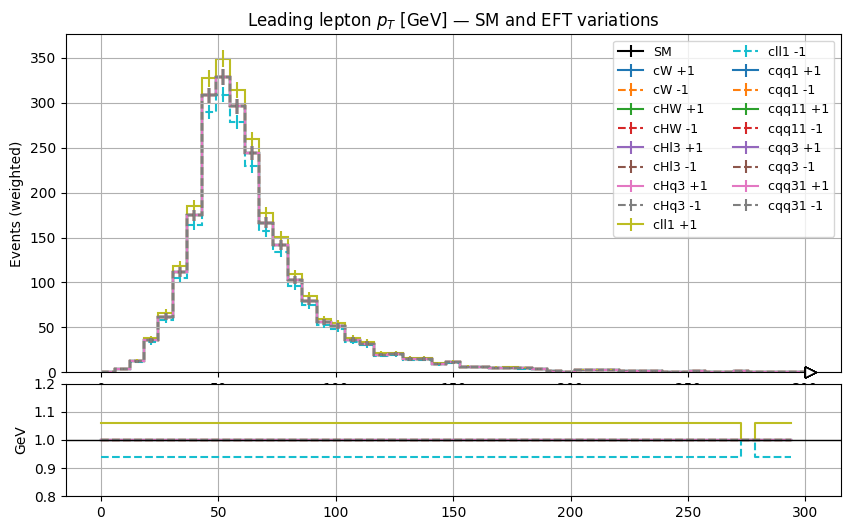

In [63]:
bins = np.linspace(0, 300, 50)
hists_ptlead = build_hist(leading_pt, weights, bins)
plot_histograms(hists_ptlead, "Leading lepton $p_T$ [GeV]", save_name="leading_pt.png")

Saved plot: Z_pt.png


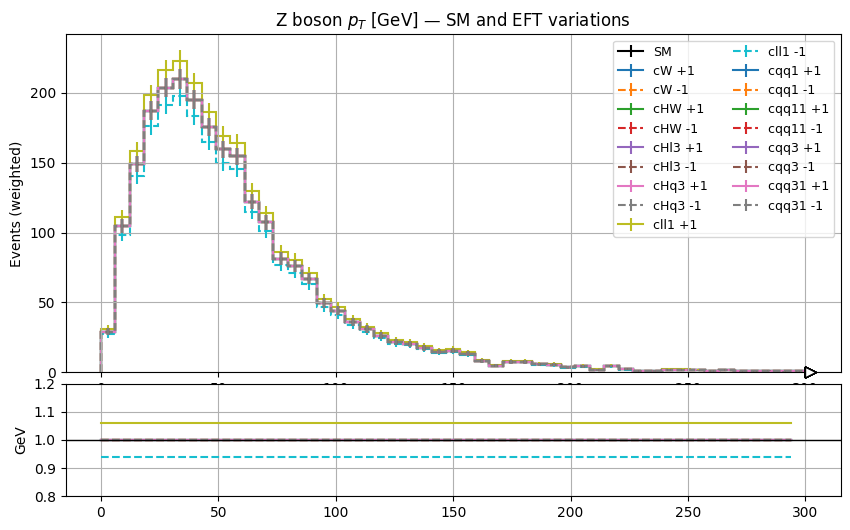

In [64]:
bins = np.linspace(0, 300, 50)
hists_Z = build_hist(Z_pt, weights, bins)
plot_histograms(hists_Z, "Z boson $p_T$ [GeV]", save_name="Z_pt.png")

Saved plot: MET.png


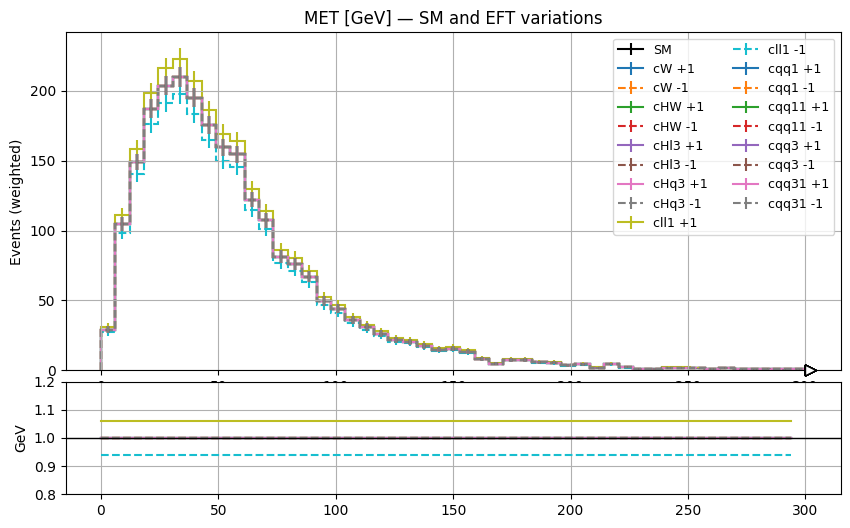

In [65]:
bins = np.linspace(0, 300, 50)
hists_MET = build_hist(MET, weights, bins)
plot_histograms(hists_MET, "MET [GeV]", save_name="MET.png")

In [66]:
#Check
unique_pid = list(set(ak.flatten(pid[neutrinos])))
print("Unique PIDs:", unique_pid)

unique_nu_counts = list(set(ak.num(nu_pt)))
print("Unique neutrino multiplicities:", unique_nu_counts)

print("Neutrino PIDs in first 10 events:", pid[neutrinos][:10])
print("Unique neutrino status codes:", list(set(ak.flatten(status[neutrinos]))))


Unique PIDs: [np.int32(12), np.int32(14), np.int32(16), np.int32(-16), np.int32(-14), np.int32(-12)]
Unique neutrino multiplicities: [np.int64(2)]
Neutrino PIDs in first 10 events: [[12, -12], [16, -16], [14, -14], [...], ..., [14, -14], [12, -12], [12, -12]]
Unique neutrino status codes: [np.int32(1)]
Unique neutrino status codes: [np.int32(1)]


In [67]:
#Check
# Flatten and convert to Python list
flattened_pids = ak.flatten(pid[neutrinos]).to_list()
unique_pids = sorted(set(flattened_pids))
print("Unique PID values in neutrino selection:", unique_pids)

# Neutrino multiplicities
nu_counts = ak.num(nu_pt).to_list()
unique_nu_counts = sorted(set(nu_counts))
print("Unique neutrino multiplicities:", unique_nu_counts)

# First 10 events' neutrino PIDs
print("Neutrino PIDs in first 10 events:")
for i in range(10):
    print(pid[neutrinos][i].to_list())

# Unique neutrino status codes
flattened_status = ak.flatten(status[neutrinos]).to_list()
unique_status = sorted(set(flattened_status))
print("Unique neutrino status codes:", unique_status)


Unique PID values in neutrino selection: [-16, -14, -12, 12, 14, 16]
Unique neutrino multiplicities: [2]
Neutrino PIDs in first 10 events:
[12, -12]
[16, -16]
[14, -14]
[12, -12]
[16, -16]
[14, -14]
[16, -16]
[14, -14]
[12, -12]
[12, -12]
Unique neutrino status codes: [1]


In [68]:
#Check
for name, idx_p, idx_m in operators:
    w_p = weights[:, idx_p]
    w_m = weights[:, idx_m]

    print(f"Operator {name}:")
    print(f"  +1 weights: mean={np.mean(w_p):.3f}, std={np.std(w_p):.3f}, min={np.min(w_p):.3f}, max={np.max(w_p):.3f}")
    print(f"  -1 weights: mean={np.mean(w_m):.3f}, std={np.std(w_m):.3f}, min={np.min(w_m):.3f}, max={np.max(w_m):.3f}")
    print()

Operator cW:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cHW:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cHl3:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cHq3:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cll1:
  +1 weights: mean=0.254, std=0.000, min=0.254, max=0.254
  -1 weights: mean=0.225, std=nan, min=0.225, max=0.225

Operator cqq1:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cqq11:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 weights: mean=0.239, std=0.000, min=0.239, max=0.239

Operator cqq3:
  +1 weights: mean=0.239, std=0.000, min=0.239, max=0.239
  -1 we

In [69]:
def plot_histograms_log(hists, xlabel, save_name=None):

    sm = hists["SM"]

    # Prepare figure
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2,1, height_ratios=[3,1], hspace=0.05)

    # Top panel: SM + EFT overlays
    ax = fig.add_subplot(gs[0])

    sm.plot(ax=ax, label="SM", color='black')    

    for name, idx_p, idx_m in operators:
        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p.plot(ax=ax, label=f"{name} +1", overlay=True)
        h_m.plot(ax=ax, label=f"{name} -1", linestyle='--', overlay=True)

    ax.set_yscale("log")
    ax.set_ylabel("Events (weighted)")
    ax.set_title(xlabel + " — SM and EFT variations")
    ax.legend(ncol=2, fontsize=9)

    # Bottom panel: EFT/SM ratios
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    sm_values = sm.values()
    bins = sm.axes[0].edges

    for name, idx_p, idx_m in operators:

        h_p = hists[f"{name}+1"]
        h_m = hists[f"{name}-1"]

        h_p_val = h_p.values()
        h_m_val = h_m.values()

        # SAFE division (NumPy arrays, no structured dtype)
        ratio_p = np.divide(h_p_val, sm_values, out=np.ones_like(h_p_val), where=sm_values != 0)
        ratio_m = np.divide(h_m_val, sm_values, out=np.ones_like(h_m_val), where=sm_values != 0)

        # Plot
        ax2.step(bins[:-1], ratio_p, label=f"{name} +1", where="mid")
        ax2.step(bins[:-1], ratio_m, label=f"{name} -1", linestyle='--', where="mid")

    ax2.axhline(1.0, color='black', linewidth=1)
    ax2.set_ylabel("EFT / SM")
    ax2.set_ylabel("GeV")
    ax2.set_ylim(0.8, 1.2)

    if save_name:
        plt.savefig(save_name, dpi=200)
        print(f"Saved plot: {save_name}")

    plt.show()


Saved plot: leading_pt_log.png


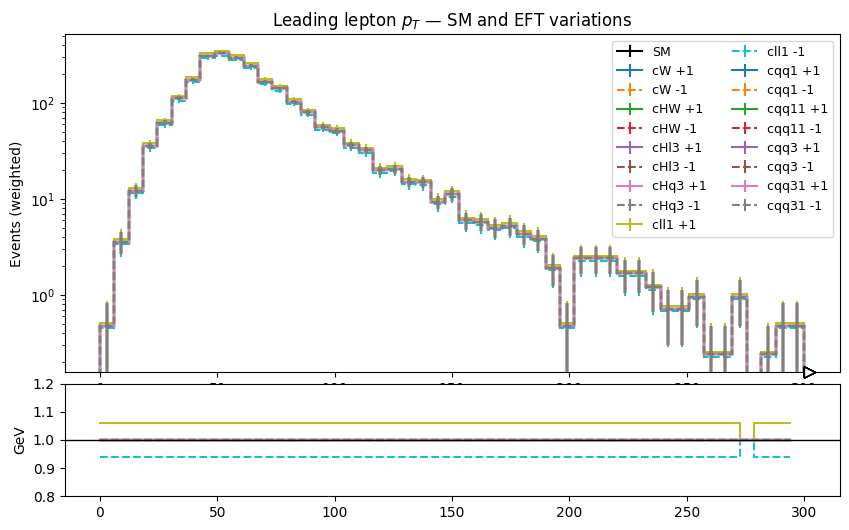

Saved plot: Z_pt_log.png


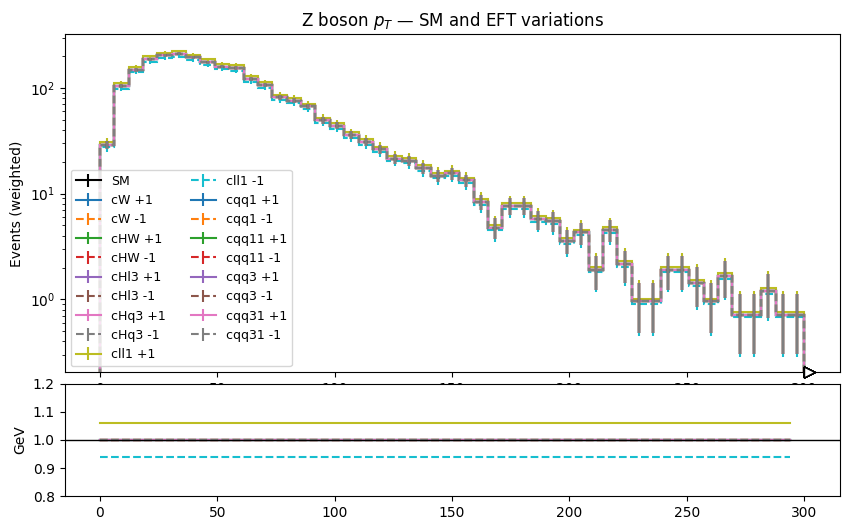

Saved plot: MET_log.png


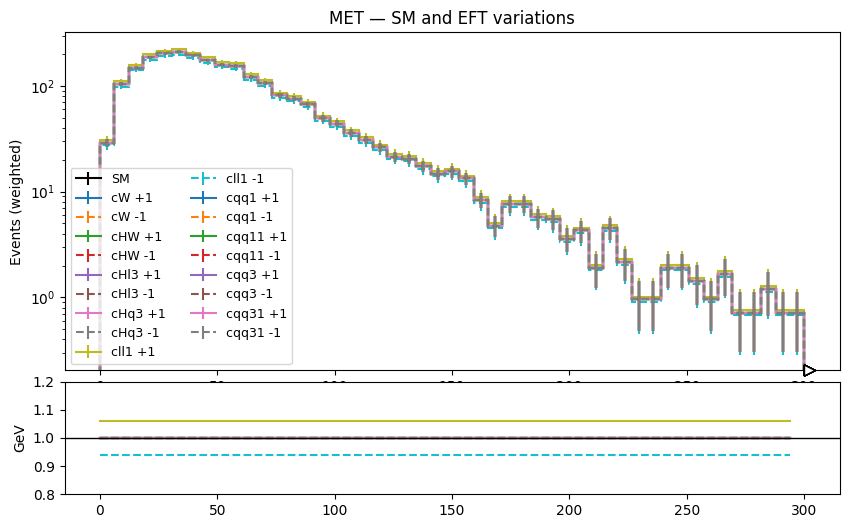

Saved plot: trailing_pt.png


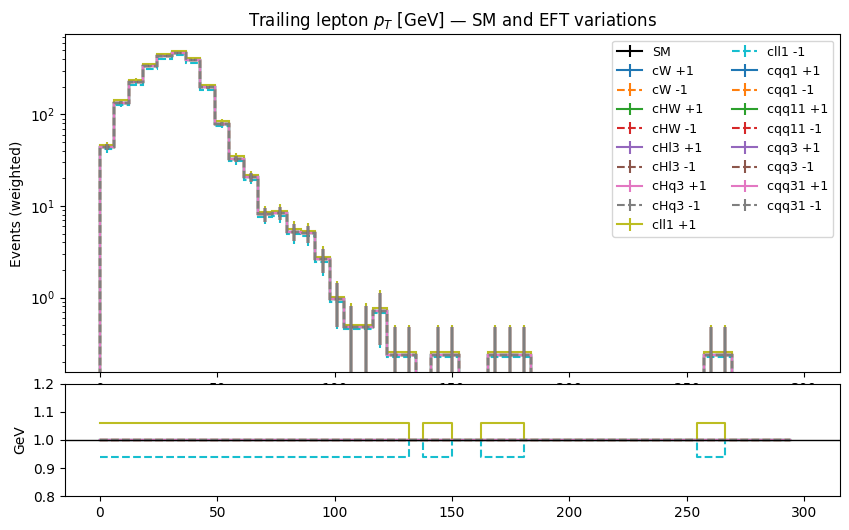

Saved plot: eta1.png


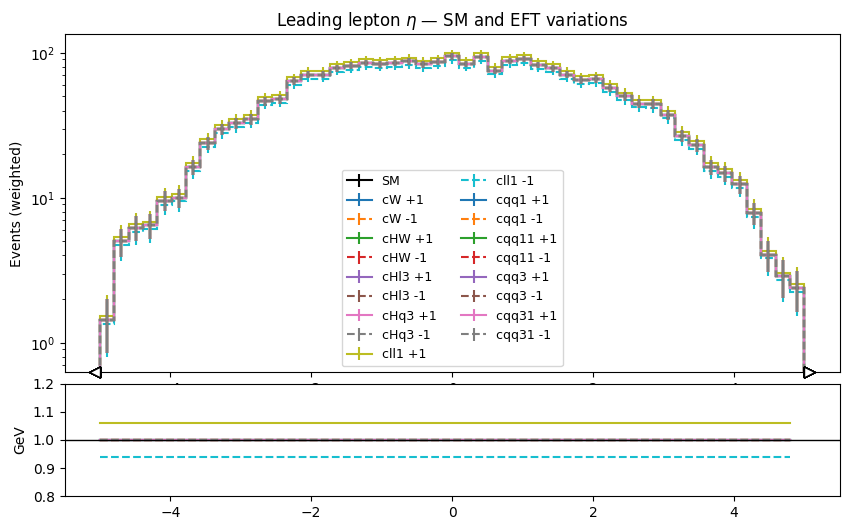

Saved plot: eta2.png


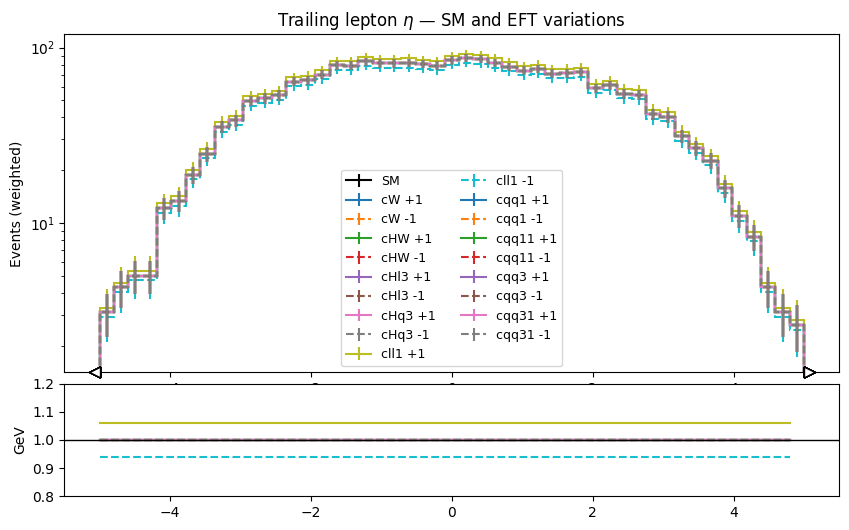

In [70]:
h_ptlead = build_hist(leading_pt, weights, bins)
plot_histograms_log(h_ptlead, "Leading lepton $p_T$", save_name="leading_pt_log.png")

h_Z = build_hist(Z_pt, weights, bins)
plot_histograms_log(h_Z, "Z boson $p_T$", save_name="Z_pt_log.png")

h_MET = build_hist(MET, weights, bins)
plot_histograms_log(h_MET, "MET", save_name="MET_log.png")

h_trailing = build_hist(trailing_pt, weights, bins)
plot_histograms_log(h_trailing, "Trailing lepton $p_T$ [GeV]", save_name="trailing_pt.png")

bins_eta = np.linspace(-5, 5, 50)

h_eta1 = build_hist(eta1, weights, bins_eta)
plot_histograms_log(h_eta1, "Leading lepton $\eta$", save_name="eta1.png")

h_eta2 = build_hist(eta2, weights, bins_eta)
plot_histograms_log(h_eta2, "Trailing lepton $\eta$", save_name="eta2.png")

In [71]:
#Focus on cll1 operator
idx_p = 9   # +1
idx_m = 10  # -1

w_sm     = ak.to_numpy(weights[:, 0])
w_cll1_p = ak.to_numpy(weights[:, idx_p])
w_cll1_m = ak.to_numpy(weights[:, idx_m])

print("Shapes:", w_sm.shape, w_cll1_p.shape, w_cll1_m.shape)


Shapes: (10000,) (10000,) (10000,)


Saved Leading lepton $p_T$_cll1.png


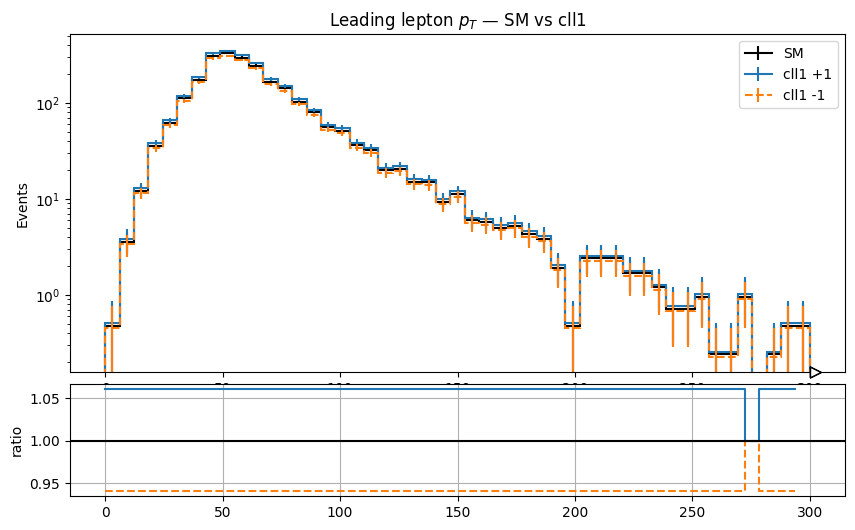

Saved Trailing lepton $p_T$_cll1.png


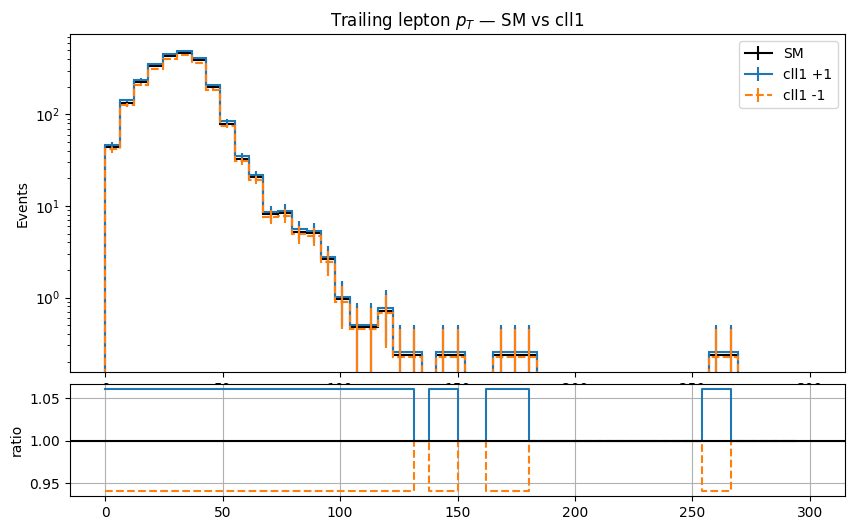

Saved Z boson $p_T$_cll1.png


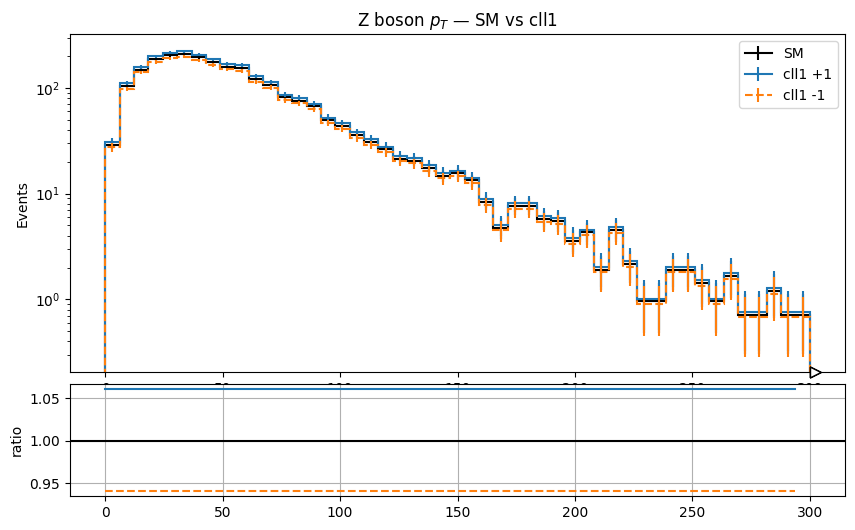

Saved MET_cll1.png


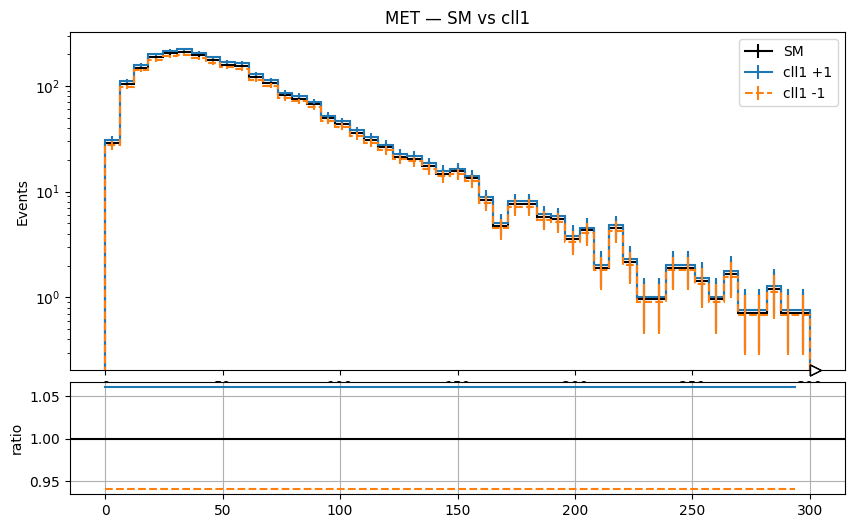

Saved Leading lepton $\eta$_cll1.png


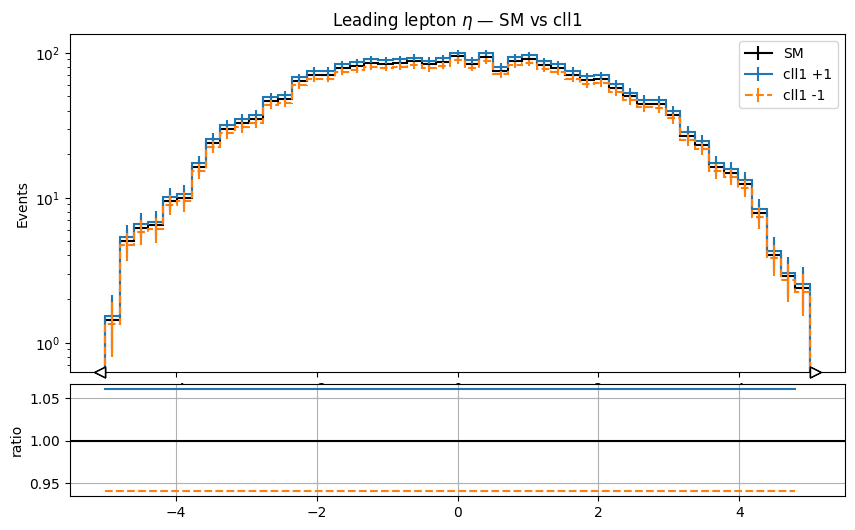

Saved Trailing lepton $\eta$_cll1.png


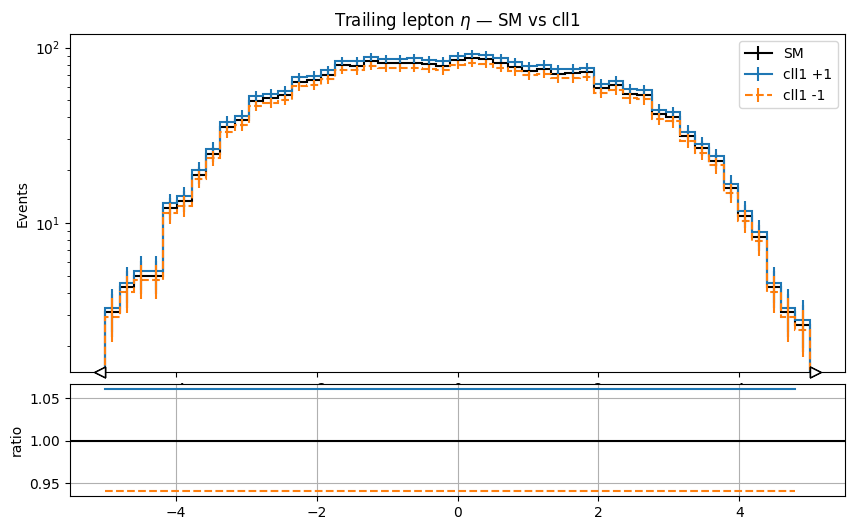

In [72]:
#build histogram for just the cll1 operator
def build_hist_cll1(obs, w_sm, w_p, w_m, bins):
    h_sm = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
    h_p  = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())
    h_m  = hist.Hist(hist.axis.Variable(bins), storage=hist.storage.Weight())

    h_sm.fill(obs, weight=w_sm)
    h_p.fill(obs,  weight=w_p)
    h_m.fill(obs,  weight=w_m)

    return {"SM": h_sm, "cll1+1": h_p, "cll1-1": h_m}

#plot histogram for cll1 operator
def plot_cll1(hists, xlabel, save=None):

    sm = hists["SM"]
    h_p = hists["cll1+1"]
    h_m = hists["cll1-1"]

    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2,1, height_ratios=[3,1], hspace=0.05)

    ax = fig.add_subplot(gs[0])

    sm.plot(ax=ax, label="SM", color='black')
    h_p.plot(ax=ax, label="cll1 +1", overlay=True)
    h_m.plot(ax=ax, label="cll1 -1", linestyle='--', overlay=True)

    ax.set_yscale('log')
    ax.set_ylabel("Events")
    ax.set_title(xlabel + " — SM vs cll1")
    ax.legend()

    # ratio panel
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    sm_vals = sm.values()
    bins = sm.axes[0].edges

    ratio_p = np.divide(h_p.values(), sm_vals, out=np.ones_like(sm_vals), where=sm_vals>0)
    ratio_m = np.divide(h_m.values(), sm_vals, out=np.ones_like(sm_vals), where=sm_vals>0)

    ax2.step(bins[:-1], ratio_p, where="mid", label="cll1 +1")
    ax2.step(bins[:-1], ratio_m, where="mid", linestyle='--', label="cll1 -1")

    ax2.axhline(1.0, color='black')
    ax2.set_ylabel("ratio")
    ax2.grid(True)

    if save:
        plt.savefig(save, dpi=200)
        print("Saved", save)

    plt.show()

#All 6 plot inuts
bins_pt  = np.linspace(0, 300, 50)
bins_eta = np.linspace(-5, 5, 50)

features = {"Leading lepton $p_T$": leading_pt, "Trailing lepton $p_T$": trailing_pt, "Z boson $p_T$": Z_pt, "MET": MET,
    "Leading lepton $\\eta$": eta1, "Trailing lepton $\\eta$": eta2}

for name, arr in features.items():
    if "eta" in name.lower():
        bins = bins_eta
    else:
        bins = bins_pt

    h = build_hist_cll1(arr, w_sm, w_cll1_p, w_cll1_m, bins)
    plot_cll1(h, name, save=f"{name}_cll1.png")


In [73]:
# ML dataset build — convert inputs to NumPy arrays
X_cll1 = np.column_stack([
	np.asarray(leading_pt),
	np.asarray(trailing_pt),
	ak.to_numpy(Z_pt),
	ak.to_numpy(MET),
	np.asarray(eta1),
	np.asarray(eta2),
])

# ML target = SM, cll1+1, cll1-1
y_cll1 = np.column_stack([w_sm, w_cll1_p, w_cll1_m])

print("X_cll1:", X_cll1.shape)
print("y_cll1:", y_cll1.shape)


X_cll1: (10000, 6)
y_cll1: (10000, 3)


In [74]:
#convert to dataframe
df_cll1 = pd.DataFrame(X_cll1, columns=["lead_pt", "trail_pt", "Z_pt", "MET", "eta1", "eta2"])

df_cll1["w_sm"]  = w_sm
df_cll1["w_p"]   = w_cll1_p
df_cll1["w_m"]   = w_cll1_m

df_cll1.head()

#save dataset as CSV and parquet formats
df_cll1.to_csv("dataset_cll1.csv", index=False)
df_cll1.to_parquet("dataset_cll1.parquet", engine='fastparquet')
print("Saved cll1 dataset.")

# Save dataset in NPZ format
np.savez("dataset_cll1.npz", X=X_cll1, y=y_cll1)
print("Saved NPZ file: dataset_cll1.npz")

data = np.load("dataset_cll1.npz")
X = data["X"]
y = data["y"]

print("Loaded shapes:", X.shape, y.shape)

Saved cll1 dataset.
Saved NPZ file: dataset_cll1.npz
Loaded shapes: (10000, 6) (10000, 3)


In [75]:
#ML-1: Classification Dataset (SM vs EFT cll1+1)

df = df_cll1.copy()

# Add ratio columns
df["w_ratio_p"] = df["w_p"] / df["w_sm"]
df["w_ratio_m"] = df["w_m"] / df["w_sm"]

feature_cols = ["lead_pt", "trail_pt", "Z_pt", "MET", "eta1", "eta2"]
X = df[feature_cols].values
n_events = len(X)

# SM samples (label=0)
X_sm  = X.copy()
y_sm  = np.zeros(n_events)
w_sm  = df["w_sm"].values

# EFT samples cll1+1 (label=1)
X_eft = X.copy()
y_eft = np.ones(n_events)
w_eft = df["w_p"].values

# Combine
X_class = np.vstack([X_sm, X_eft])
y_class = np.concatenate([y_sm, y_eft])
w_class = np.concatenate([w_sm, w_eft])

# Normalize weights
w_class = w_class / w_class.sum() * len(w_class)

# Train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X_class, y_class, w_class, test_size=0.2, random_state=42, stratify=y_class)

# Scaling for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Classification dataset ready:")
print(f"  Train: {len(X_train)}, Test: {len(X_test)}")


Classification dataset ready:
  Train: 16000, Test: 4000


In [76]:
#ML-2: Train Classification Models

models = {}
results = {}

print("\n Training Classification Models \n")

#1) Gradient Boosted Trees 
if HAS_XGB:
    model_gbt = xgb.XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.07, subsample=0.9, colsample_bytree=0.9,
        eval_metric='logloss', random_state=42    )
    model_gbt.fit(X_train, y_train, sample_weight=w_train)
else:
    model_gbt = GradientBoostingClassifier(n_estimators=200, learning_rate=0.07, max_depth=3, random_state=42)
    model_gbt.fit(X_train, y_train, sample_weight=w_train)

models["GBT"] = model_gbt
pred_gbt = model_gbt.predict_proba(X_test)[:,1]

results["GBT"] = {
    "auc": roc_auc_score(y_test, pred_gbt, sample_weight=w_test),
    "acc": accuracy_score(y_test, pred_gbt>0.5)
}

print(f"GBT  AUC = {results['GBT']['auc']:.4f},  Acc = {results['GBT']['acc']:.4f}")


#2) MLP (2-layer)
model_mlp = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', solver='adam', learning_rate='adaptive', max_iter=300,
    early_stopping=True, random_state=42)
model_mlp.fit(X_train_scaled, y_train)

pred_mlp = model_mlp.predict_proba(X_test_scaled)[:,1]
results["MLP"] = {"auc": roc_auc_score(y_test, pred_mlp, sample_weight=w_test), "acc": accuracy_score(y_test, pred_mlp>0.5)}

print(f"MLP  AUC = {results['MLP']['auc']:.4f},  Acc = {results['MLP']['acc']:.4f}")


#3) Random Forest
model_rf = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_leaf=10, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train, sample_weight=w_train)

pred_rf = model_rf.predict_proba(X_test)[:,1]
results["RF"] = {"auc": roc_auc_score(y_test, pred_rf, sample_weight=w_test), "acc": accuracy_score(y_test, pred_rf>0.5)}

print(f"RF   AUC = {results['RF']['auc']:.4f},  Acc = {results['RF']['acc']:.4f}")


 Training Classification Models 

GBT  AUC = 0.1608,  Acc = 0.2787
GBT  AUC = 0.1608,  Acc = 0.2787
MLP  AUC = 0.4880,  Acc = 0.4973
MLP  AUC = 0.4880,  Acc = 0.4973
RF   AUC = 0.2882,  Acc = 0.4625
RF   AUC = 0.2882,  Acc = 0.4625


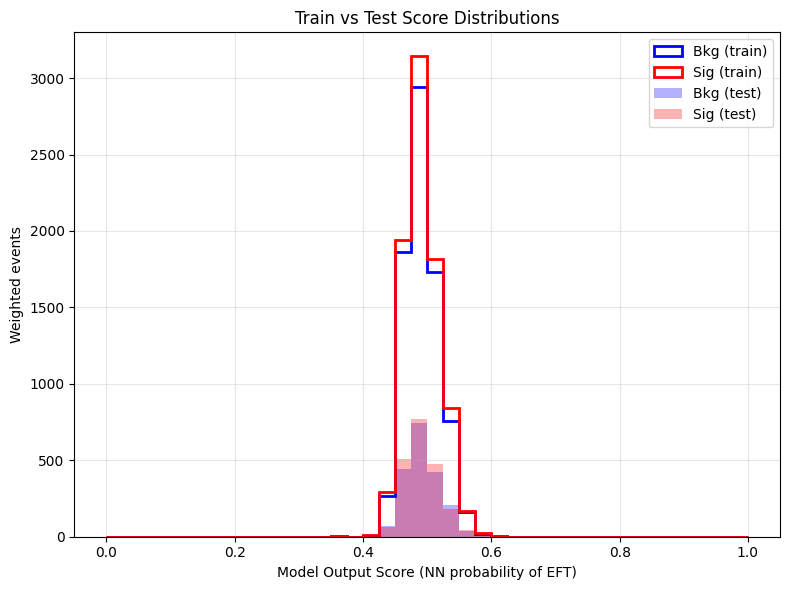

In [95]:
# Use the MLP scores (replace with GBT or RF if needed)
score_train = model_mlp.predict_proba(X_train_scaled)[:, 1]
score_test  = model_mlp.predict_proba(X_test_scaled)[:, 1]

# Separate signal vs background
train_sig  = score_train[y_train == 1]
train_bkg  = score_train[y_train == 0]
test_sig   = score_test[y_test == 1]
test_bkg   = score_test[y_test == 0]

w_train_sig = w_train[y_train == 1]
w_train_bkg = w_train[y_train == 0]
w_test_sig  = w_test[y_test == 1]
w_test_bkg  = w_test[y_test == 0]

plt.figure(figsize=(8,6))
plt.grid(alpha=0.3)

# Plot training distributions
plt.hist(train_bkg, bins=40, range=(0,1), weights=w_train_bkg, histtype='step', color='blue',  lw=2, label='Bkg (train)')
plt.hist(train_sig, bins=40, range=(0,1), weights=w_train_sig, histtype='step', color='red',   lw=2, label='Sig (train)')

# Plot test distributions
plt.hist(test_bkg, bins=40, range=(0,1), weights=w_test_bkg, histtype='stepfilled', alpha=0.3, color='blue', label='Bkg (test)')
plt.hist(test_sig, bins=40, range=(0,1), weights=w_test_sig, histtype='stepfilled', alpha=0.3, color='red',  label='Sig (test)')

plt.xlabel("Model Output Score (NN probability of EFT)")
plt.ylabel("Weighted events")
plt.title("Train vs Test Score Distributions")
plt.legend()
plt.tight_layout()
plt.show()


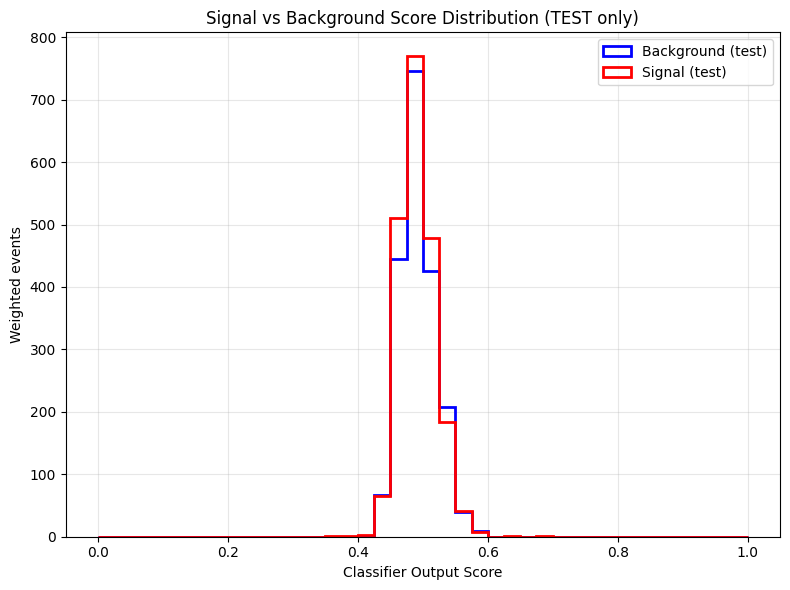

In [78]:
plt.figure(figsize=(8,6))
plt.grid(alpha=0.3)

# Score distributions on TEST only
plt.hist(score_test[y_test==0], bins=40, range=(0,1), weights=w_test[y_test==0], histtype='step', lw=2, color='blue', label="Background (test)")
plt.hist(score_test[y_test==1], bins=40, range=(0,1), weights=w_test[y_test==1], histtype='step', lw=2, color='red', label="Signal (test)")

plt.xlabel("Classifier Output Score")
plt.ylabel("Weighted events")
plt.title("Signal vs Background Score Distribution (TEST only)")
plt.legend()
plt.tight_layout()
plt.show()


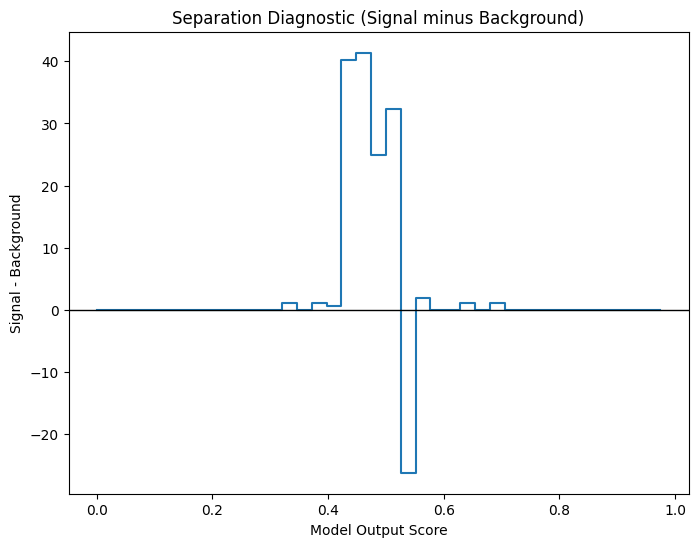

In [79]:
plt.figure(figsize=(8,6))
bins = np.linspace(0,1,40)
hist_sig, _ = np.histogram(score_test[y_test==1], bins=bins, weights=w_test[y_test==1])
hist_bkg, _ = np.histogram(score_test[y_test==0], bins=bins, weights=w_test[y_test==0])

plt.step(bins[:-1], hist_sig - hist_bkg, where='mid')
plt.axhline(0, color='black', lw=1)
plt.xlabel("Model Output Score")
plt.ylabel("Signal - Background")
plt.title("Separation Diagnostic (Signal minus Background)")
plt.show()


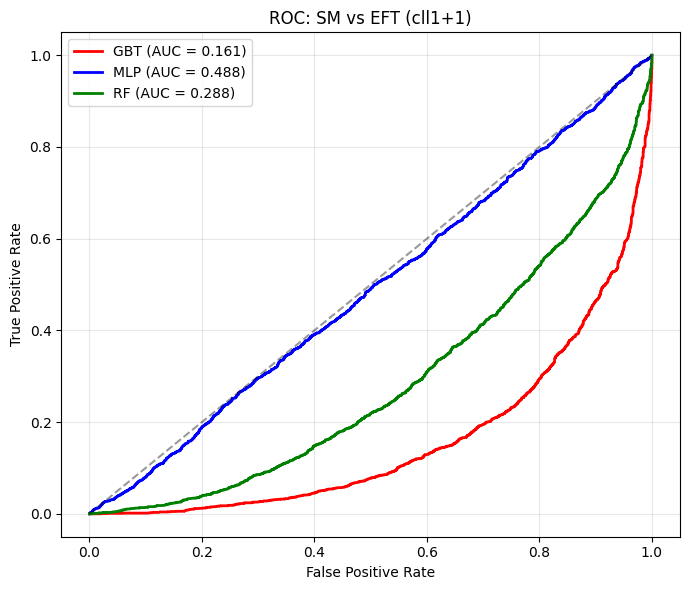

Saved ROC curves plot: roc_curves.png


<Figure size 640x480 with 0 Axes>

In [80]:
#ML-3: ROC Curves

plt.figure(figsize=(7,6))
plt.grid(True, alpha=0.3)

preds = {"GBT": pred_gbt, "MLP": pred_mlp, "RF": pred_rf}
colors = {"GBT":"red", "MLP":"blue", "RF":"green"}

for name, pred in preds.items():
    fpr, tpr, _ = roc_curve(y_test, pred, sample_weight=w_test)
    plt.plot(fpr, tpr, color=colors[name], lw=2,
             label=f"{name} (AUC = {results[name]['auc']:.3f})")

plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: SM vs EFT (cll1+1)")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("roc_curves.png", dpi=200, bbox_inches='tight')
print("Saved ROC curves plot: roc_curves.png")


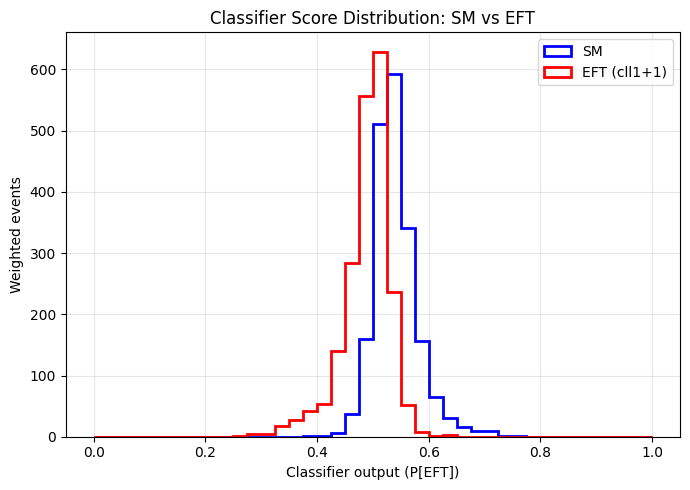

In [81]:
# Histogram of classifier output (example using GBT; replace with pred_mlp or pred_rf if desired)

plt.figure(figsize=(7,5))
plt.grid(alpha=0.3)

# Predictions already computed:
# pred_gbt = model_gbt.predict_proba(X_test)[:,1]

# Separate SM and EFT events in test set
pred_sm  = pred_gbt[y_test == 0]
pred_eft = pred_gbt[y_test == 1]

w_sm_test  = w_test[y_test == 0]
w_eft_test = w_test[y_test == 1]

# Plot the histograms
plt.hist(pred_sm,  bins=40, range=(0,1), weights=w_sm_test,
         histtype='step', lw=2, color='blue', label='SM')

plt.hist(pred_eft, bins=40, range=(0,1), weights=w_eft_test,
         histtype='step', lw=2, color='red', label='EFT (cll1+1)')

plt.xlabel("Classifier output (P[EFT])")
plt.ylabel("Weighted events")
plt.title("Classifier Score Distribution: SM vs EFT")
plt.legend()
plt.tight_layout()
plt.show()


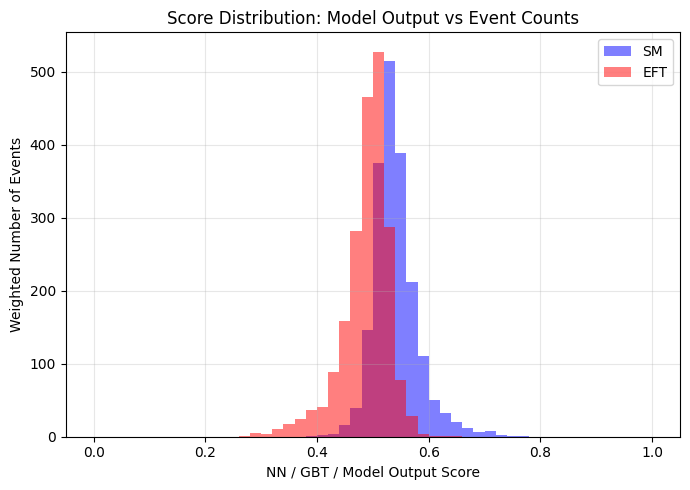

In [82]:
# Score distribution (example uses GBT scores; replace with pred_mlp or pred_rf if needed)

plt.figure(figsize=(7,5))
plt.grid(alpha=0.3)

# Separate SM and EFT events in the test set
score_sm  = pred_gbt[y_test == 0]
score_eft = pred_gbt[y_test == 1]

w_sm_evt  = w_test[y_test == 0]
w_eft_evt = w_test[y_test == 1]

# Histogram: event count vs NN output
plt.hist(score_sm,  bins=50, range=(0,1), weights=w_sm_evt,
         histtype='stepfilled', alpha=0.5, color='blue', label='SM')

plt.hist(score_eft, bins=50, range=(0,1), weights=w_eft_evt,
         histtype='stepfilled', alpha=0.5, color='red', label='EFT')

plt.xlabel("NN / GBT / Model Output Score")
plt.ylabel("Weighted Number of Events")
plt.title("Score Distribution: Model Output vs Event Counts")
plt.legend()
plt.tight_layout()
plt.show()


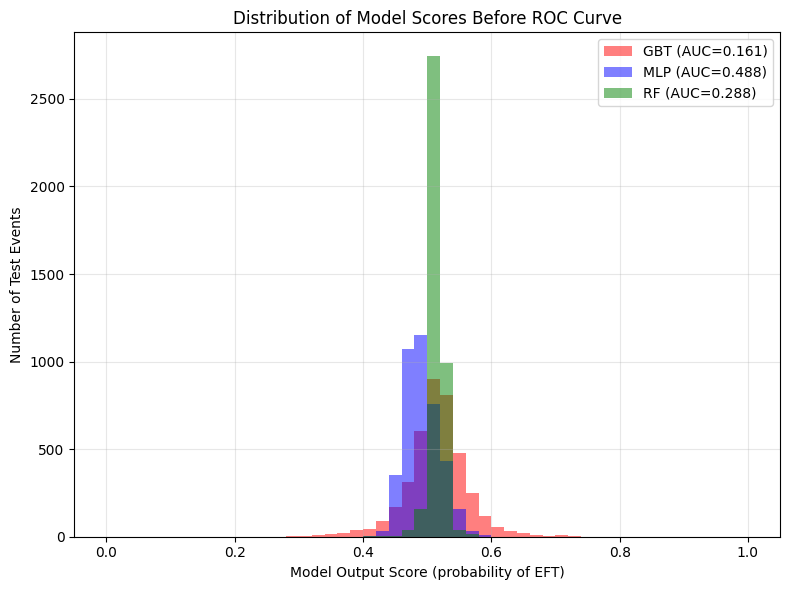

In [84]:
# Histogram of model output scores for ALL MODELS (GBT, MLP, RF)

plt.figure(figsize=(8,6))
plt.grid(alpha=0.3)

# Plot one histogram per model (all events)
plt.hist(pred_gbt, bins=50, range=(0,1), alpha=0.5, label=f"GBT (AUC={results['GBT']['auc']:.3f})", color='red')
plt.hist(pred_mlp, bins=50, range=(0,1), alpha=0.5, label=f"MLP (AUC={results['MLP']['auc']:.3f})", color='blue')
plt.hist(pred_rf,  bins=50, range=(0,1), alpha=0.5, label=f"RF (AUC={results['RF']['auc']:.3f})",  color='green')

plt.xlabel("Model Output Score (probability of EFT)")
plt.ylabel("Number of Test Events")
plt.title("Distribution of Model Scores Before ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Computing SHAP values...


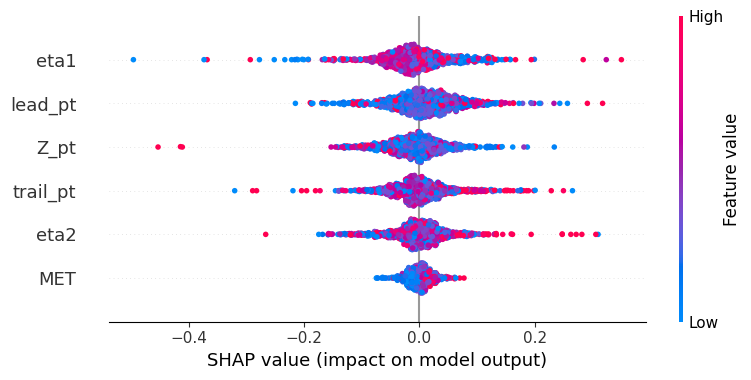

Saved plot: SHAP_Values.png


<Figure size 640x480 with 0 Axes>

In [85]:
#ML-4: SHAP Analysis

try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False

if HAS_SHAP:
    print("Computing SHAP values...")
    explainer = shap.TreeExplainer(model_gbt)
    shap_vals = explainer.shap_values(X_test[:1000])

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]  # take EFT class

    shap.summary_plot(shap_vals, X_test[:1000], feature_names=feature_cols)
    plt.savefig("SHAP_Values.png", dpi=200, bbox_inches='tight')
    print("Saved plot: SHAP_Values.png")
else:
    print("SHAP not installed.")

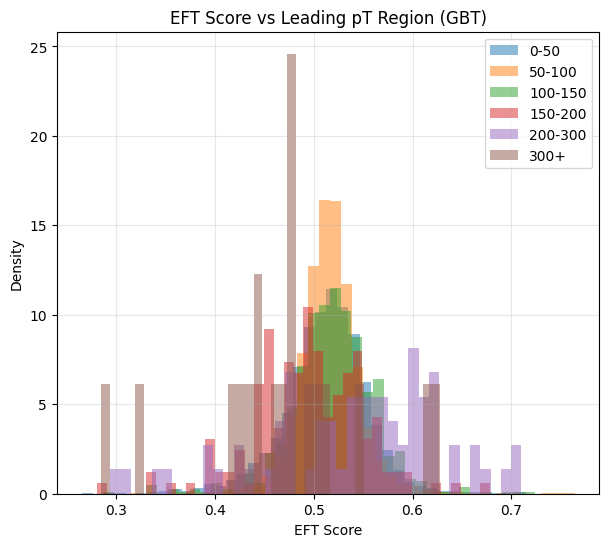

Saved ROC curves plot: EFT_Score_vs_lead_pT.png


<Figure size 640x480 with 0 Axes>

In [86]:
#ML-5: EFT score vs leading pT

df["eft_score"] = model_gbt.predict_proba(df[feature_cols])[:,1]

bins = [0, 50, 100, 150, 200, 300, np.inf]
labels = ["0-50", "50-100", "100-150", "150-200", "200-300", "300+"]

df["pt_region"] = pd.cut(df["lead_pt"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(7,6))
for region in labels:
    mask = df["pt_region"] == region
    plt.hist(df.loc[mask, "eft_score"], bins=40, alpha=0.5, label=region, density=True)

plt.xlabel("EFT Score")
plt.ylabel("Density")
plt.title("EFT Score vs Leading pT Region (GBT)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.savefig("EFT_Score_vs_lead_pT.png", dpi=200, bbox_inches='tight')
print("Saved ROC curves plot: EFT_Score_vs_lead_pT.png")

In [87]:
#ML-6: Classification Summary

print(" CLASSIFICATION RESULTS ")
for name, res in results.items():
    print(f"{name:4s}:  AUC={res['auc']:.4f},  ACC={res['acc']:.4f}")


 CLASSIFICATION RESULTS 
GBT :  AUC=0.1608,  ACC=0.2787
MLP :  AUC=0.4880,  ACC=0.4973
RF  :  AUC=0.2882,  ACC=0.4625


In [88]:
#REG-0: Regression dataset

df_reg = df.copy()

X_reg = df_reg[feature_cols].values
y_reg = df_reg["w_ratio_p"].values

# Clean
valid = np.isfinite(X_reg).all(axis=1) & np.isfinite(y_reg)
X_reg = X_reg[valid]
y_reg = y_reg[valid]

# Split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale for MLP
scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s  = scaler_r.transform(Xr_test)

print("Regression dataset ready.")

Regression dataset ready.


In [89]:
#REG-1: Train Regression Models

reg_models = {}
reg_results = {}

# --- GBT Regressor ---
gbt_reg = GradientBoostingRegressor(n_estimators=300, max_depth=3, learning_rate=0.07, random_state=42)
gbt_reg.fit(Xr_train, yr_train)
reg_models["GBT"] = gbt_reg

pred_gbt_r = gbt_reg.predict(Xr_test)
reg_results["GBT"] = {"mse": mean_squared_error(yr_test, pred_gbt_r), "r2": r2_score(yr_test, pred_gbt_r)}

# --- MLP Regressor ---
mlp_reg = MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", solver="adam", max_iter=300, random_state=42, early_stopping=True)
mlp_reg.fit(Xr_train_s, yr_train)
reg_models["MLP"] = mlp_reg

pred_mlp_r = mlp_reg.predict(Xr_test_s)
reg_results["MLP"] = {"mse": mean_squared_error(yr_test, pred_mlp_r), "r2": r2_score(yr_test, pred_mlp_r)}

# --- Random Forest Regressor ---
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=6, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf_reg.fit(Xr_train, yr_train)
reg_models["RF"] = rf_reg

pred_rf_r = rf_reg.predict(Xr_test)
reg_results["RF"] = {"mse": mean_squared_error(yr_test, pred_rf_r), "r2": r2_score(yr_test, pred_rf_r)}

print("\nRegression results:")
for name,res in reg_results.items():
    print(f"{name}: R2={res['r2']:.4f}, MSE={res['mse']:.4e}")


Regression results:
GBT: R2=1.0000, MSE=0.0000e+00
MLP: R2=0.0000, MSE=2.3297e-02
RF: R2=0.0000, MSE=2.6268e-27


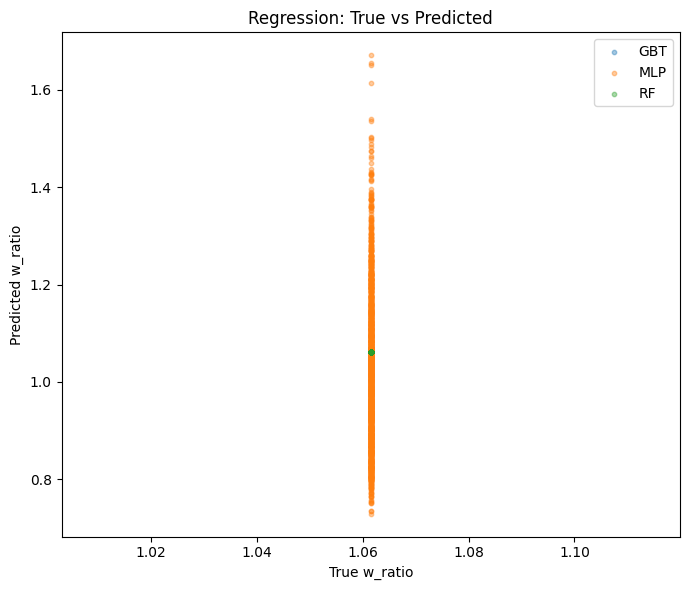

Saved ROC curves plot: Regression_True_vsPred.png


<Figure size 640x480 with 0 Axes>

In [90]:
#REG-2: Scatter true vs predicted

plt.figure(figsize=(7,6))
for name, preds in zip(["GBT","MLP","RF"], [pred_gbt_r, pred_mlp_r, pred_rf_r]):
    plt.scatter(yr_test, preds, s=10, alpha=0.4, label=f"{name}")

lims = [min(yr_test.min(), np.min(pred_gbt_r)), max(yr_test.max(), np.max(pred_gbt_r))]
plt.plot(lims, lims, 'k--')
plt.xlabel("True w_ratio")
plt.ylabel("Predicted w_ratio")
plt.legend()
plt.title("Regression: True vs Predicted")
plt.tight_layout()
plt.show()

plt.savefig("Regression_True_vsPred.png", dpi=200, bbox_inches='tight')
print("Saved ROC curves plot: Regression_True_vsPred.png")


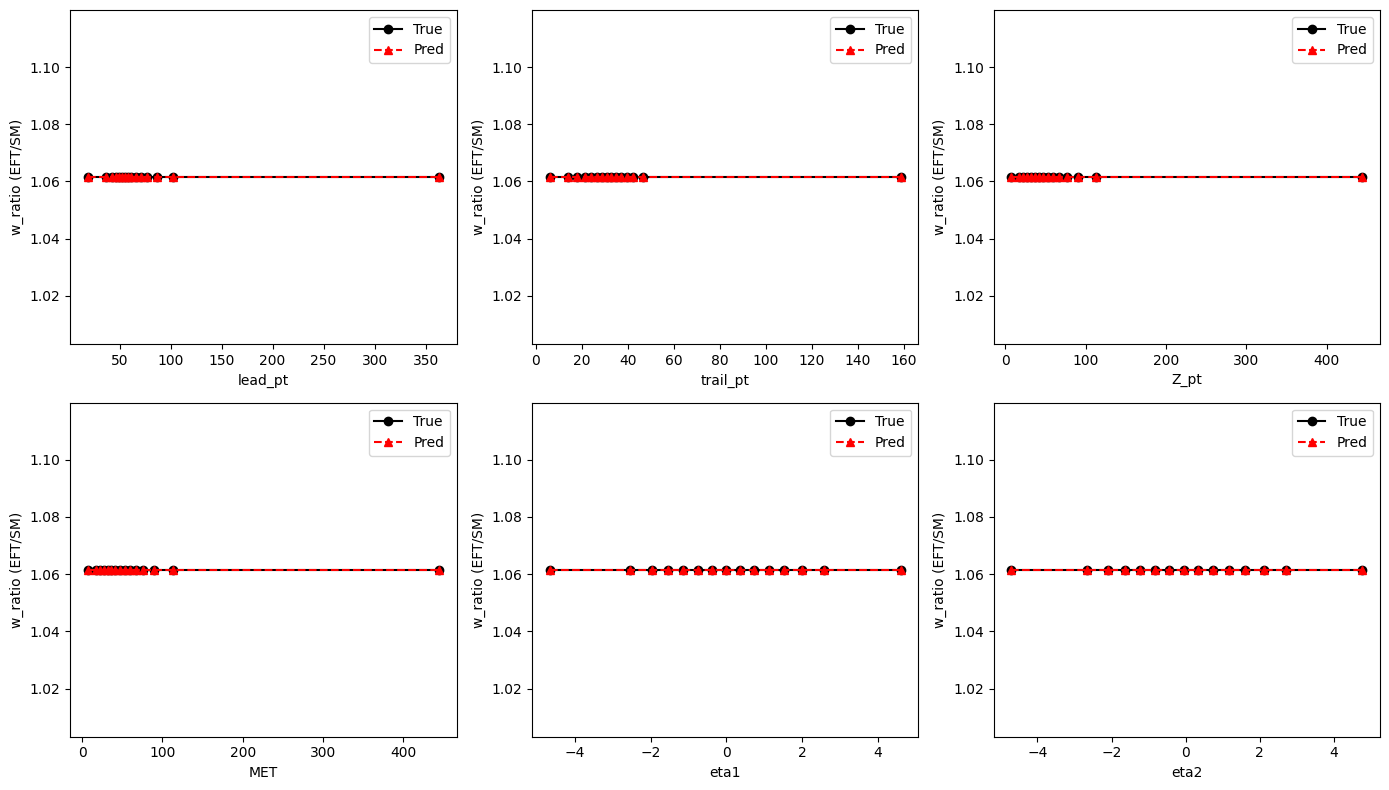

Saved ROC curves plot: Learned_EFT_dep.png


<Figure size 640x480 with 0 Axes>

In [91]:
#REG-3: Learned EFT dependence vs features

gbt_best = gbt_reg
pred_all = gbt_best.predict(X_reg)

fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    vals = X_reg[:,i]

    bins = np.percentile(vals, np.linspace(0,100,16))
    centers = 0.5*(bins[:-1]+bins[1:])
    means_true = []
    means_pred = []

    for j in range(len(bins)-1):
        m = (vals>=bins[j]) & (vals<bins[j+1])
        means_true.append(y_reg[m].mean() if m.sum()>5 else np.nan)
        means_pred.append(pred_all[m].mean() if m.sum()>5 else np.nan)

    ax.plot(centers, means_true, 'ko-', label="True")
    ax.plot(centers, means_pred, 'r^--', label="Pred")

    ax.set_xlabel(col)
    ax.set_ylabel("w_ratio (EFT/SM)")
    ax.legend()

plt.tight_layout()
plt.show()

plt.savefig("Learned_EFT_dep.png", dpi=200, bbox_inches='tight')
print("Saved ROC curves plot: Learned_EFT_dep.png")


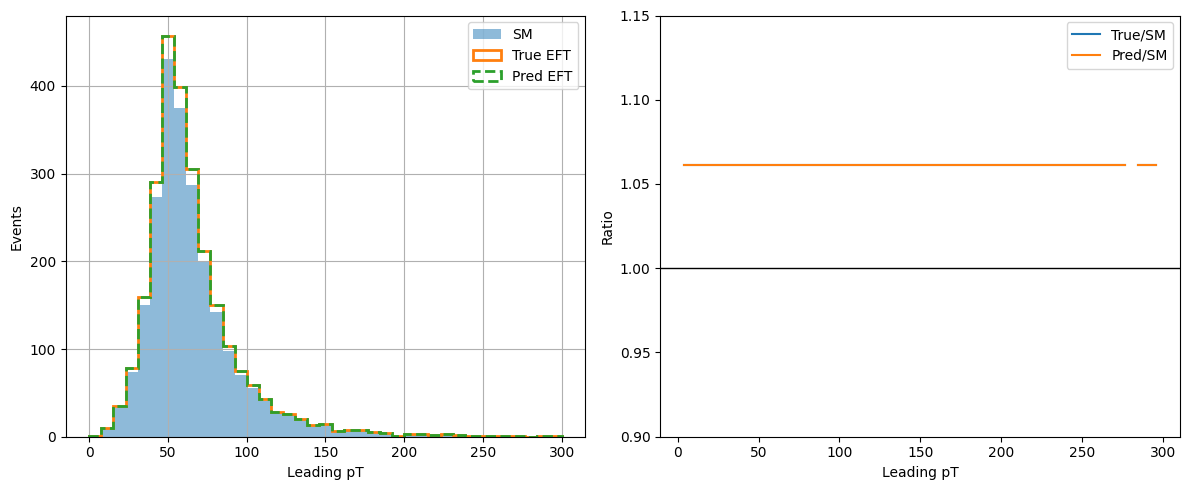

Saved ROC curves plot: Closure_Test.png


<Figure size 640x480 with 0 Axes>

In [92]:
#REG-4: Closure test

w_sm_all = df["w_sm"].values
w_true_eft = df["w_p"].values

w_pred_ratio = gbt_best.predict(df[feature_cols])
w_pred_eft = w_sm_all * w_pred_ratio

bins = np.linspace(0,300,40)

plt.figure(figsize=(12,5))

# --- Histogram
plt.subplot(1,2,1)
plt.hist(df["lead_pt"], bins=bins, weights=w_sm_all, alpha=0.5, label="SM")
plt.hist(df["lead_pt"], bins=bins, weights=w_true_eft, histtype="step", lw=2, label="True EFT")
plt.hist(df["lead_pt"], bins=bins, weights=w_pred_eft, histtype="step", lw=2, linestyle="--", label="Pred EFT")
plt.xlabel("Leading pT")
plt.ylabel("Events")
plt.legend()
plt.grid(True)

# --- Ratio
plt.subplot(1,2,2)
h_sm,_  = np.histogram(df["lead_pt"], bins=bins, weights=w_sm_all)
h_true,_= np.histogram(df["lead_pt"], bins=bins, weights=w_true_eft)
h_pred,_= np.histogram(df["lead_pt"], bins=bins, weights=w_pred_eft)

ratio_true = h_true / h_sm
ratio_pred = h_pred / h_sm
centers = 0.5*(bins[:-1]+bins[1:])

plt.step(centers, ratio_true, where='mid', label="True/SM")
plt.step(centers, ratio_pred, where='mid', label="Pred/SM")
plt.axhline(1, color='k', lw=1)
plt.ylim(0.9, 1.15)
plt.xlabel("Leading pT")
plt.ylabel("Ratio")
plt.legend()

plt.tight_layout()
plt.show()

plt.savefig("Closure_Test.png", dpi=200, bbox_inches='tight')
print("Saved ROC curves plot: Closure_Test.png")


In [93]:
#REG-5: Summary

print("REGRESSION RESULTS")
for name,res in reg_results.items():
    print(f"{name}:  R2={res['r2']:.4f},  MSE={res['mse']:.4e}")

REGRESSION RESULTS
GBT:  R2=1.0000,  MSE=0.0000e+00
MLP:  R2=0.0000,  MSE=2.3297e-02
RF:  R2=0.0000,  MSE=2.6268e-27
